# Hierarchical clustering of Pa 14 resistant samples

In this notebook we are going to analyse the merged output files of SNPeff variants annotation and SnpSift fields extract to build a hierarchical clustering tree of the samples.

This line gives us a larger view of the notebook.

In [23]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

First, we install the necessary library.


In [1]:
!conda install -y biopython
!conda install -y -c anaconda scikit-bio 
!conda install -y pandasql

Fetching package metadata ...........
Solving package specifications: ..........

# All requested packages already installed.
# packages in environment at /opt/conda/envs/python2:
#
biopython                 1.69                np112py27_0  
Fetching package metadata .............
Solving package specifications: ..........
  - anaconda::intel-openmp-2018.0.0-8.tar.bz2
  - anaconda::intel-openmp-2018.0.0-hc7b2577_8.tar.bz2

Package plan for installation in environment /opt/conda/envs/python2:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB  anaconda
    intel-openmp-2018.0.0      |                8         620 KB  anaconda
    libgcc-ng-7.2.0            |       hdf63c60_3         6.1 MB  anaconda
    libgfortran-ng-7.2.0       |       hdf63c60_3         1.2 MB  anaconda
    libstdcxx-ng-7.2.0         |       hdf63c60_3         

Then we import the useful modules.

In [2]:
import pandas as pd
from pandasql import *
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
import pylab

pysqldf = lambda q: sqldf(q, globals())
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
import scipy
from scipy.spatial.distance import squareform, pdist
from Bio.Phylo.TreeConstruction import _Matrix

from Bio.Phylo.TreeConstruction import _DistanceMatrix
import skbio
import os
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import SeqIO


/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


### Plotting Strand Bias

The strand Bias is a sequencing bias that result in an inbalance of infered genotype from the positive and negative strand. We want to eliminate the variants where the strand bias is too high.

The strand bias has been calculated on Galaxy using the tool "compute on column" using the following equations (from https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-666) :  


Calculation Strand Bias : 

 a -  Forward strand reference allele = SRF column (5) 

 b - Forward strand non reference allele = SAF column (7) 

 c - Reverse strand reference allele = SRR column (6) 

 d - Reverse strand non reference allele = SAR column (8) 

``` SB: SB is defined as ∣∣(b/(a+b))−(d/(c+d))∣∣/((b+d)/(a+b+c+d))
SB =  ∣∣(SAF/(SRF+SAF))−(SAR/(SRR+SAR))∣∣/((SAF+SAR)/(SRF+SAF+SRR+SAR))
SB =  abs((SAF/(SRF+SAF))−(SAR/(SRR+SAR)))/((SAF+SAR)/(SRF+SAF+SRR+SAR))
SB =  abs(((c6/(c6+c8))-(c7/(c9+c7)))) / ((c6+c7)/(c9+c6+c7+c8) ) (Formula applied in Compute Column tool)```

Import of the file resulting of collection collapse snpsift output collection, and plotting of the Strand Bias repartition

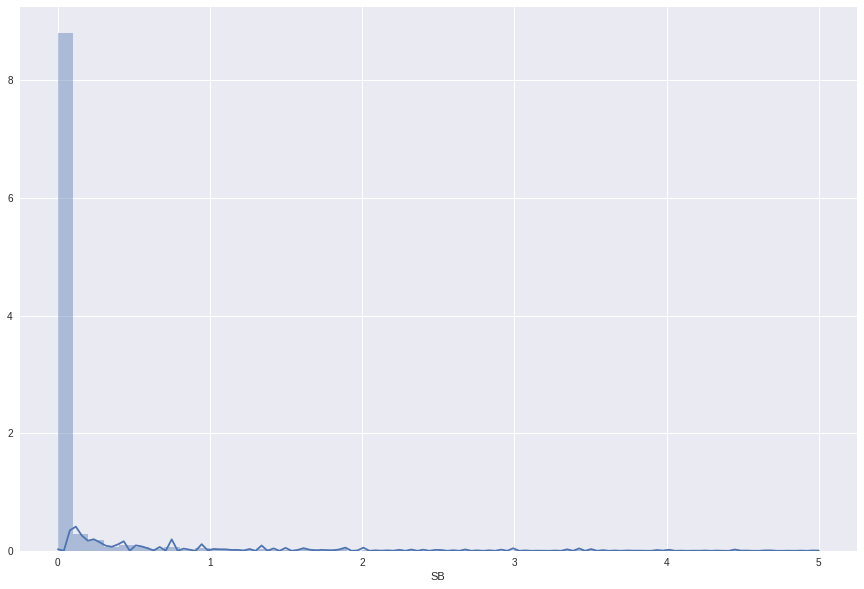

In [24]:
collapsed = pd.read_table(get(1766))

fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 10) ) 
sns.distplot(collapsed["SB"]);
display(fig)

We can see that the Strand Bias is in majority <2 , we therefore applied a filter to the snpsift output to select the variants with a Strand Bias <2 

##  Import and cleaning of input files

The input files has been obtained by applying several filters on the variants annotation : 
 * EFFECT!='intergenic_region' : Keep only the variants in intragenic regions
 * ',' not in ALT
 * strand_bias<2
        

Import files into the notebook : 
 * The joined file is the file resulting of a collumn join on snpsift output collection

In [4]:
joined = pd.read_table(get(2571))



The output of SnpSift returns a tabulated files with header containing cracayers that may cause problems further into the analysis. We therefore need to replace the problematic caracters in the column names

In [5]:
for i in joined.columns.values : 
    joined=joined.rename(index=str, columns={i:i.replace('.','_').replace('[*]_','_')})


As we may need the original version of the data later in the analysis we are creating a working copy of the Dataframe.

In [6]:
sequences=joined.copy()

Let's take a look at the data

In [7]:
sequences.head()

,id,SRR5363633_wtP_fq_CHROM,SRR5363633_wtP_fq_POS,SRR5363633_wtP_fq_REF,SRR5363633_wtP_fq_ALT,SRR5363633_wtP_fq_QUAL,SRR5363633_wtP_fq_SAF,SRR5363633_wtP_fq_SAR,SRR5363633_wtP_fq_SRF,SRR5363633_wtP_fq_SRR,...,SRR5363715_cip_fq_SRP,SRR5363715_cip_fq_EPP,SRR5363715_cip_fq_DP,SRR5363715_cip_fq_EFF_GENEID,SRR5363715_cip_fq_EFF_GENE,SRR5363715_cip_fq_EFF_EFFECT,SRR5363715_cip_fq_EFF_AA,SRR5363715_cip_fq_EFF_IMPACT,SRR5363715_cip_fq_EFF_FUNCLASS,SRR5363715_cip_fq_SB
0,.-1031233.0-GA,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
1,.-1053012.0-G,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
2,.-1117713.0-G,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
3,.-1135136.0-C,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
4,.-1144646.0-C,NC_008463,1144646,C,G,8583.5,181,86,0,0,...,0.0,3.13803,17,.,.,.,.,.,.,0.0


You can see that the dataframe has an big number of collumns, including the information in 15 columns for each variants. Most of the frames are empty, meaning the sample does not present the variant.
Several information are redundant of won't be used in this analysis. In order to avoid carrying along data we won't need, we are creating lists of the data we won't use to filter out the dataFrame : 
Columns of interest :
 * A list of columns containing the sequence of reference
 * A list of collumn contining the gene impacted by the variation
 * A list of collumn contining the alternative sequence
 * A list containing the collumns we will need for this analysis


In [8]:
regexREF=re.compile(".*(REF).*") # List of columns containing the reference allele of the variant
listREF=list(filter(regexREF.match,joined.columns.values))
listsamples= [ i.replace('_fq_REF','') for i in listREF ] #list of sample names
regexGENE=re.compile(".*(GENE).*") # List of columns containing the gene impacted by the variant
listGENE=list(filter(regexGENE.match,joined.columns.values))
regexALT=re.compile(".*(ALT).*") # List of columns containing the alternative allele of the variant
listALT=list(filter(regexALT.match,joined.columns.values))
regexclean=re.compile(".*(_GENE)|(IMPACT)|(FUNCLASS).*") # List of columns we want to filter out (Neither gene impacted, impact nor functionnal class)
listrefsalts=list(filter(lambda i: not regexclean.search(i),sequences.columns.values))


Now that we identified our interesting collumn, we can delete the other ones

In [9]:
for i in listrefsalts[1:]:
    del sequences[i]


In [10]:
sequences.head()

,id,SRR5363633_wtP_fq_EFF_GENEID,SRR5363633_wtP_fq_EFF_GENE,SRR5363633_wtP_fq_EFF_IMPACT,SRR5363633_wtP_fq_EFF_FUNCLASS,SRR5363634_con_fq_EFF_GENEID,SRR5363634_con_fq_EFF_GENE,SRR5363634_con_fq_EFF_IMPACT,SRR5363634_con_fq_EFF_FUNCLASS,SRR5363635_con_fq_EFF_GENEID,...,SRR5363713_cip_fq_EFF_IMPACT,SRR5363713_cip_fq_EFF_FUNCLASS,SRR5363714_cip_fq_EFF_GENEID,SRR5363714_cip_fq_EFF_GENE,SRR5363714_cip_fq_EFF_IMPACT,SRR5363714_cip_fq_EFF_FUNCLASS,SRR5363715_cip_fq_EFF_GENEID,SRR5363715_cip_fq_EFF_GENE,SRR5363715_cip_fq_EFF_IMPACT,SRR5363715_cip_fq_EFF_FUNCLASS
0,.-1031233.0-GA,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
1,.-1053012.0-G,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
2,.-1117713.0-G,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
3,.-1135136.0-C,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
4,.-1144646.0-C,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.


We now reduced the number of collumns to 333.

In this analysis we are interested in clustering the samples depending on the genes that are modified and how much they are modified.
In order to do that we want to groupe the variants per genes and provide a modification score.


The first Step is to create an additionnal column to the dataframe to store the information of the impacted gene, and then parse the dataframe to find the gene impacted by each variant.


In [11]:
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
sequences['GENE']="NaN"
for i, row in sequences.iterrows() :
    for j in listGENE :
        if row[j]!='.':
            sequences.loc[i,('GENE')]=row[j]
            break

Now that we have regrouped the gene information in a single collumn we can delete the collumns containing the gene impacted for each sample, now redundant with the 'GENE' column.

In [12]:
for i in listGENE:
    del sequences[i]



Now that we have the gene impacted for each variant, we need to quantify the impact of each variant on the gene. in order to do that we attributed a number reflecting the strength of each type of impact.

In the Dataframe, we are therefore replacing the "IMPACT" column with numerical values depending on the strength of the effect : 
 * No variant results on a value of 0 impact
 * A Low impact variant with a "SILENT" Functional class results on a value of 0 impact
 * A Low impact variant results on a value of 100 impact
 * A Medium impact variant results on a value of 200 impact
 * A High impact variant results on a value of 300 impact
 * A Modifier variant results on a value of 50 impact

From http://snpeff.sourceforge.net/SnpEff_manual.html : 
    
| Impact | Meaning | Example |
| ------------ | ----------- | -----------: |
| HIGH | The variant is assumed to have high (disruptive) impact in the protein, probably causing protein truncation, loss of function or triggering nonsense mediated decay. | stop_gained, frameshift_variant |
| MODERATE      |   A non-disruptive variant that might change protein effectiveness.    | missense_variant, inframe_deletion |
| LOW |     Assumed to be mostly harmless or unlikely to change protein behavior.      | synonymous_variant |
| MODIFIER     |  Usually non-coding variants or variants affecting non-coding genes, where predictions are difficult or there is no evidence of impact.  | exon_variant, downstream_gene_variant |


In [13]:
for i, row in sequences.iterrows() :
    for j in listsamples :
        if row[j+'_fq_EFF_IMPACT']=='.':
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] and 'SILENT'in row[j+'_fq_EFF_FUNCLASS'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=100
        elif 'MODERATE'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=200
        elif 'HIGH'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=300
        else : 
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=50
        

 Now that we are done using the functionnal class information, we can remove the the funclass columns.

In [14]:
for j in listsamples :
    del sequences[j+'_fq_EFF_FUNCLASS']

Let's see what our data look like now

In [15]:
sequences.head()

,id,SRR5363633_wtP_fq_EFF_IMPACT,SRR5363634_con_fq_EFF_IMPACT,SRR5363635_con_fq_EFF_IMPACT,SRR5363636_con_fq_EFF_IMPACT,SRR5363637_con_fq_EFF_IMPACT,SRR5363638_con_fq_EFF_IMPACT,SRR5363639_con_fq_EFF_IMPACT,SRR5363640_con_fq_EFF_IMPACT,SRR5363641_con_fq_EFF_IMPACT,...,SRR5363707_cip_fq_EFF_IMPACT,SRR5363708_cip_fq_EFF_IMPACT,SRR5363709_cip_fq_EFF_IMPACT,SRR5363710_cip_fq_EFF_IMPACT,SRR5363711_cip_fq_EFF_IMPACT,SRR5363712_cip_fq_EFF_IMPACT,SRR5363713_cip_fq_EFF_IMPACT,SRR5363714_cip_fq_EFF_IMPACT,SRR5363715_cip_fq_EFF_IMPACT,GENE
0,.-1031233.0-GA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,.-1053012.0-G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,.-1117713.0-G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,.-1135136.0-C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,.-1144646.0-C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


We have a dataframe containing the position of the variant, the gene impacted, and for each sample the strengh of the impact.

We now whant to create a Matrix grouping the variants by gene impacted : the different variant impacts are added for a result reflecting the global impact of all variants on one gene.

In [16]:
#Creation of an empty matri with header = list of samples
matgene=pd.DataFrame(columns=sequences.columns.values[1:-1])
# Group rows by gene, summing the row content for collumns contining variants
matgene = sequences.groupby(['GENE'])[sequences.columns.values[1:-1]].sum()

Let's take a look at our data

In [17]:
matgene.head()

,SRR5363633_wtP_fq_EFF_IMPACT,SRR5363634_con_fq_EFF_IMPACT,SRR5363635_con_fq_EFF_IMPACT,SRR5363636_con_fq_EFF_IMPACT,SRR5363637_con_fq_EFF_IMPACT,SRR5363638_con_fq_EFF_IMPACT,SRR5363639_con_fq_EFF_IMPACT,SRR5363640_con_fq_EFF_IMPACT,SRR5363641_con_fq_EFF_IMPACT,SRR5363642_con_fq_EFF_IMPACT,...,SRR5363706_cip_fq_EFF_IMPACT,SRR5363707_cip_fq_EFF_IMPACT,SRR5363708_cip_fq_EFF_IMPACT,SRR5363709_cip_fq_EFF_IMPACT,SRR5363710_cip_fq_EFF_IMPACT,SRR5363711_cip_fq_EFF_IMPACT,SRR5363712_cip_fq_EFF_IMPACT,SRR5363713_cip_fq_EFF_IMPACT,SRR5363714_cip_fq_EFF_IMPACT,SRR5363715_cip_fq_EFF_IMPACT
GENE,,,,,,,,,,,,,,,,,,,,,
NaN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PA14_00050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,200,0,200
PA14_00490,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
PA14_00510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PA14_00740,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200


We now have a Dataframe containing only the amount of modification of each gene in each sample. We are going to use these data to build a distance matrix.

In [18]:
#distance =  lambda column1, column2: pd.np.linalg.norm(column1 - column2) # Euclidian Distance
#distance = lambda column1, column2: scipy.stats.pearsonr(column1, column2)[0] # Pearson correlation coefficient
distance = lambda column1, column2: (column1 - column2).abs().sum() / len(column1) # % Difference
distdf = matgene.apply(lambda col1: matgene.apply(lambda col2: distance(col1, col2)))


The function that we want to use to builde a hierarchical tree doesn't take dataframes as imput. We therefore change the type and format of the distance matrix.

In [19]:
dstmattril=np.tril(distdf) # make it a lower triangular matrix
namessample= [str(x).replace("_fq_EFF_IMPACT","") for x in distdf.columns.values] #Remove unnecessary parts of sample names for more readability
# make it a list of lists 
dstmattril= [list(x) for x in dstmattril] 
altDistmat=list()
for i in range(0,len(distdf.columns.values)):
    altDistmat.append(dstmattril[i][:i+1])

Now that we have our distance matrix at the right format, we are building a clustering tree from the distance matrix (Here using neighor joining algorithm) and save the tree in newick format in a file

In [21]:
distmattree = _DistanceMatrix(names=namessample, matrix=altDistmat)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distmattree)
Phylo.write(tree,'pa_14_resistance.nwk', 'newick')

1

In [22]:
put('pa_14_resistance.nwk')